# Code

In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import numpy as np
import math
import torch
from tqdm.notebook import tqdm
import seaborn as sns
from torch.utils.data import DataLoader
# if its_jupyter_notebook:
#     sys.argv = [''] #Remove this if it's not a jupyter notebook!

import sys
sys.path.insert(0, '..')
#from config import *
from dataset.data import (
    RNADataset,
    EasyPosAugment,
    InteractionSelectionPolicy,
    EasyNegAugment,
    HardPosAugment,
    HardNegAugment,
    SmartNegAugment,
    plot_sample,
    #plot_sample2,
    seed_everything,
)
from config import *

In [4]:
set_data = 'training' 
assert set_data in ['training', 'val', 'test']
df_genes = pd.read_csv(os.path.join(processed_files_dir, "df_genes.csv"))
df = pd.read_csv(os.path.join(processed_files_dir, "final_df.csv"))
subset_file = os.path.join(rna_rna_files_dir, f"gene_pairs_{set_data}.txt")

# Data loader train

In [5]:
limit_small_rna = MAX_RNA_SIZE + 1000
limit_medium_rna = int(MAX_RNA_SIZE * 1.5)

df_small = df[(df.length_1<=limit_small_rna)&(df.length_2<=limit_small_rna)].reset_index(drop=True)
df_big = df[(df.length_1>limit_medium_rna)&(df.length_2>limit_medium_rna)].reset_index(drop=True)
df_medium = df[~df.couples.isin(set(df_small.couples).union(set(df_big.couples)))].reset_index(drop=True)
assert (df_small.shape[0]+df_medium.shape[0]+df_big.shape[0]) == df.shape[0]
perc_small = np.round(df_small.shape[0]/df.shape[0]*100, 1)
perc_medium = np.round(df_medium.shape[0]/df.shape[0]*100, 1)
perc_big = np.round(df_big.shape[0]/df.shape[0]*100, 1)
print(f'The amount of data (in the entire dataset) that will be sampled once is {perc_small}% ')
print(f'The amount of data (in the entire dataset) that will be sampled twice is {perc_medium}% ')
print(f'The amount of data (in the entire dataset) that will be sampled 3 times is {perc_big}% ')

The amount of data (in the entire dataset) that will be sampled once is 65.6% 
The amount of data (in the entire dataset) that will be sampled twice is 33.0% 
The amount of data (in the entire dataset) that will be sampled 3 times is 1.4% 


In [6]:
def create_sample_dict(id_couple, sample):
        d = {
            'id_sample':id_couple,
            'couple':sample.couple_id,
            'gene1':sample.gene1,
            'gene2':sample.gene2,
            'x1':sample.bbox.x1,
            'x2':sample.bbox.x2,
            'y1':sample.bbox.y1,
            'y2':sample.bbox.y2,
            'interacting':sample.interacting,
            'policy':sample.policy,
            'cdna1':sample.gene1_info["cdna"][sample.bbox.x1:sample.bbox.x2],
            'cdna2':sample.gene2_info["cdna"][sample.bbox.y1:sample.bbox.y2],
            'seed_x1':sample.seed_interaction_bbox.x1,
            'seed_x2':sample.seed_interaction_bbox.x2,
            'seed_y1':sample.seed_interaction_bbox.y1,
            'seed_y2':sample.seed_interaction_bbox.y2,
            'protein_coding1':sample.gene1_info["protein_coding"],
            'protein_coding2':sample.gene2_info["protein_coding"],
            'original_length1':len(sample.gene1_info["cdna"]),
            'original_length2':len(sample.gene2_info["cdna"]),
        }
        return d

def get_dataset(ep_per_sample, sn_per_sample, en_persample, hn_per_sample, df_genes, df, subset_file, pos_width_multipliers, pos_height_multipliers, neg_width_windows, neg_height_windows):
    assert np.round(sum(pos_width_multipliers.values()), 4) == np.round(sum(neg_width_windows.values()), 4) == 1
    pol = [
        EasyPosAugment(
        per_sample=ep_per_sample,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_width_multipliers,
        height_multipliers=pos_height_multipliers,
        ),
        SmartNegAugment(
            per_sample=sn_per_sample,
            interaction_selection=InteractionSelectionPolicy.LARGEST,
            width_multipliers=pos_width_multipliers,
            height_multipliers=pos_height_multipliers,
        ),
        EasyNegAugment(
            per_sample=en_persample,
            width_windows=neg_width_windows,
            height_windows=neg_height_windows,
        ),
    ]
    if hn_per_sample>0:
        pol.append(
            HardNegAugment(
                per_sample=hn_per_sample,
                width_windows=neg_width_windows,
                height_windows=neg_height_windows,
            )
        )
    dataset = RNADataset(
            gene2info=df_genes,
            interactions=df,
            subset_file=subset_file,
            augment_policies=pol,
    )
    return dataset 

def create_gene_count(df, unbalanced_ratio):
    gene_count = pd.concat([df[['gene1', 'interacting']].rename({'gene1':'gene'}, axis = 1),
                            df[['gene2','interacting']].rename({'gene2':'gene'}, axis = 1)], axis = 0).reset_index(drop = True)
    g = gene_count.groupby('gene').sum()
    g['not_interacting'] = gene_count.groupby('gene').count() - gene_count.groupby('gene').sum()
    g['not_interacting'] = g['not_interacting']*unbalanced_ratio
    g = g.reset_index() #add the gene column from the index
    g['diff'] = g['not_interacting'] - g['interacting']
    g['abs_diff'] = g['diff'].abs()
    g['tot'] = g['interacting'] + g['not_interacting']
    g['abs_diff_weighted'] = g['tot']*g['abs_diff']
    return g

In [7]:
pos_width_multipliers = {1000000: 1.}
pos_height_multipliers = pos_width_multipliers
neg_width_windows = {(MAX_RNA_SIZE-1, MAX_RNA_SIZE): float(1),}
neg_height_windows = neg_width_windows

id_couple = 0
meta = {}

In [8]:
small_train = get_dataset(ep_per_sample=1, sn_per_sample=1, en_persample=0.2, hn_per_sample=0, 
                          df_genes=df_genes, df=df_small, subset_file=subset_file, 
                          pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                          neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(small_train), total = len(small_train)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
medium_train = get_dataset(ep_per_sample=2, sn_per_sample=2, en_persample=0.2, hn_per_sample=1, 
                           df_genes=df_genes, df=df_medium, subset_file=subset_file,
                           pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                           neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(medium_train), total = len(medium_train)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1
    
    
big_train = get_dataset(ep_per_sample=3, sn_per_sample=3, en_persample=0.2, hn_per_sample=3, 
                        df_genes=df_genes, df=df_big, subset_file=subset_file, 
                        pos_width_multipliers=pos_width_multipliers, pos_height_multipliers=pos_height_multipliers, 
                        neg_width_windows=neg_width_windows, neg_height_windows=neg_height_windows)

for i, sample in tqdm(enumerate(big_train), total = len(big_train)):
    meta[id_couple] = create_sample_dict(id_couple, sample)
    id_couple += 1

  0%|          | 0/127401 [00:00<?, ?it/s]

  0%|          | 0/143376 [00:00<?, ?it/s]

  0%|          | 0/10395 [00:00<?, ?it/s]

In [10]:
df_meta = pd.DataFrame.from_dict(meta, 'index')

m = df_meta[df_meta.policy.isin({'smartneg', 'easypos'})]
assert (m.seed_x1 >= m.x1).all()
assert (m.seed_y1 >= m.y1).all()
assert ((m.seed_x2) <= (m.x2)).all()
assert ((m.seed_y2) <= (m.y2)).all()

93092 14845
6.2709329740653414


/data01/gbini/projects/RNA-RNA/src/../dataset/data.py:1307: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot([0, width],[0, height], 'ro', color = 'white')


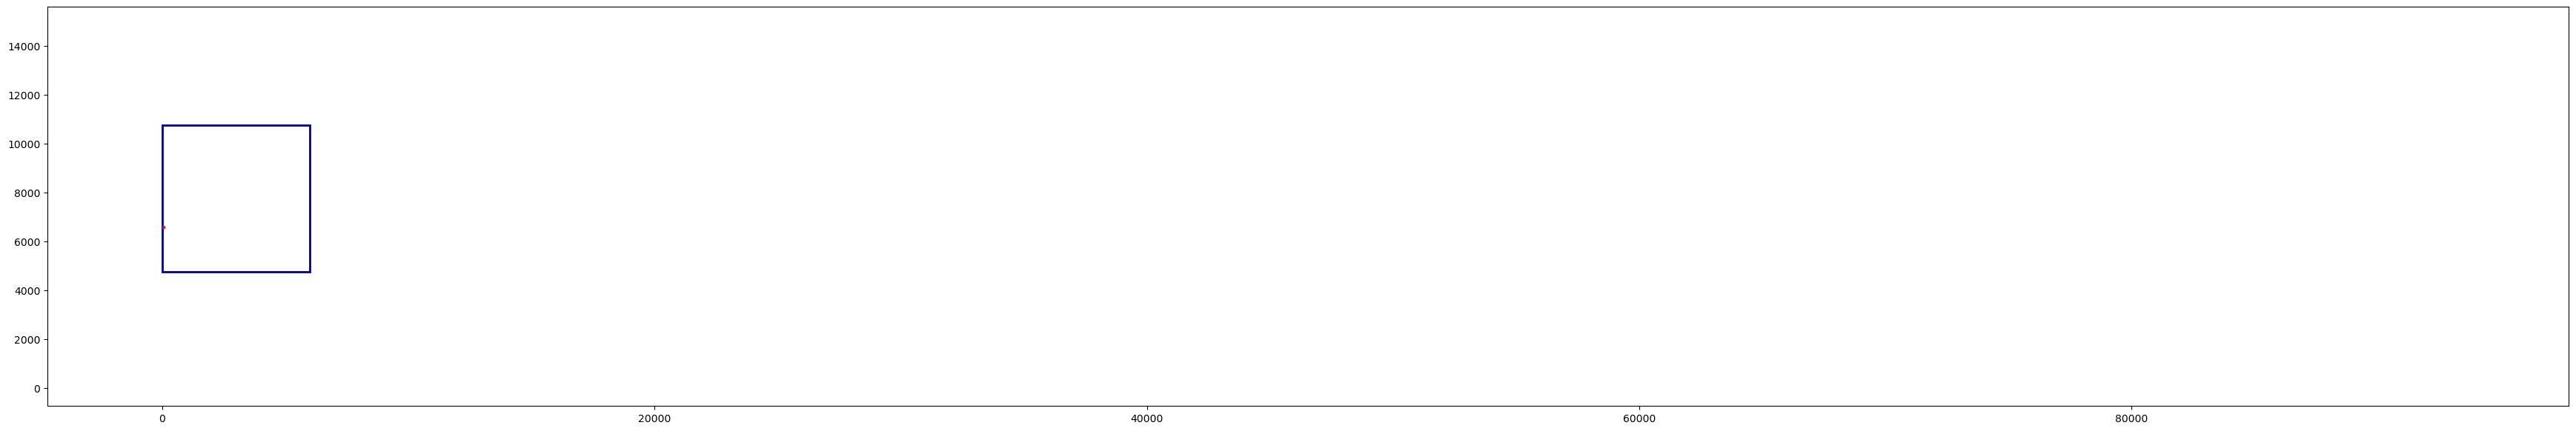

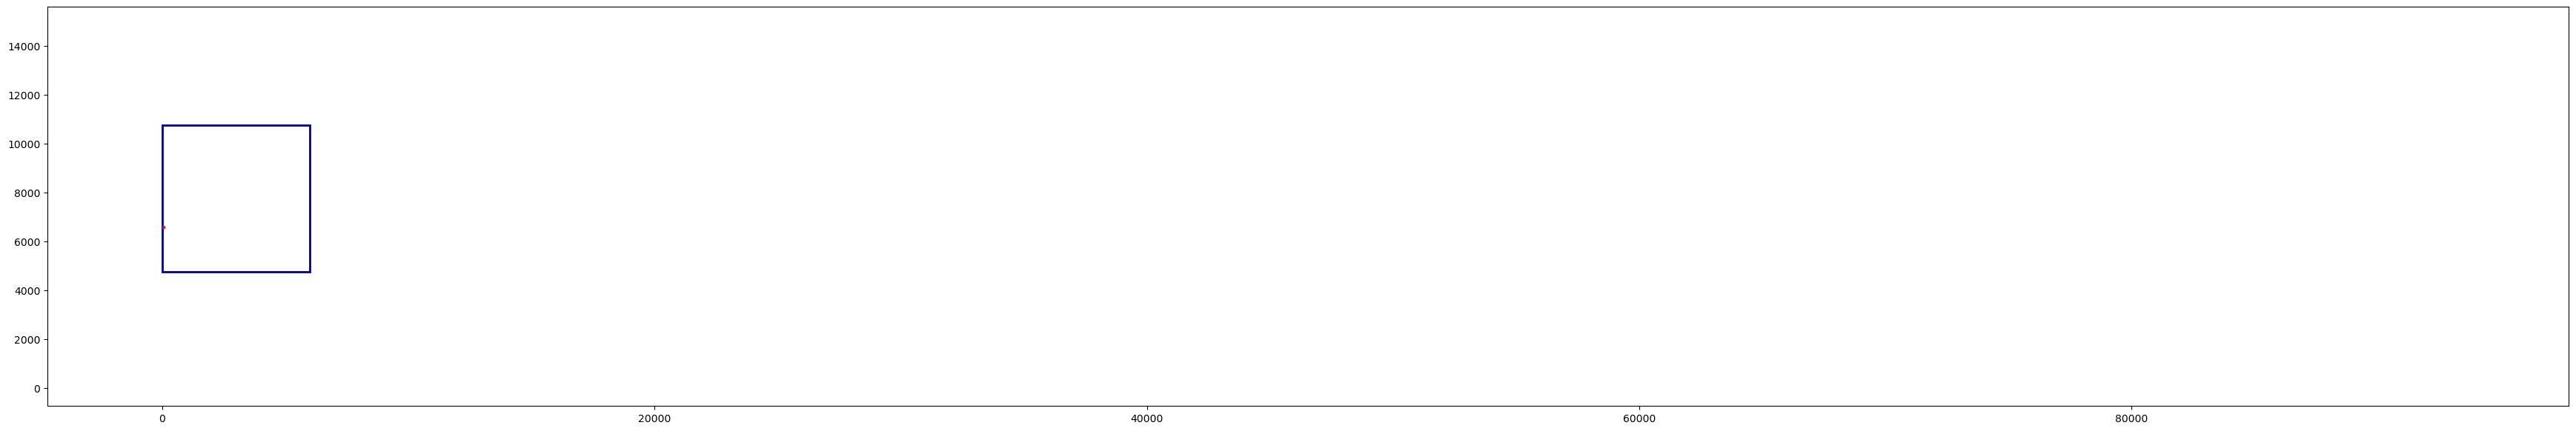

In [20]:
plot_sample(sample, True)

### Controllo se alcuni geni hanno un arricchimento solo nei positivi o solo nei negativi.

In [11]:
original_shape = df_meta.shape[0]

In [12]:
unbalanced_ratio = df_meta.interacting.value_counts()[True]/df_meta.interacting.value_counts()[False]
print(f'unbalanced_ratio:{unbalanced_ratio:.2f}')

gene_count = create_gene_count(df_meta, unbalanced_ratio)
weighted_average = np.round(gene_count['abs_diff_weighted'].sum()/gene_count['tot'].sum(),2)
print(f'{weighted_average=}')
df_meta = df_meta.merge(gene_count[['gene', 'diff']], left_on = 'gene1', right_on = 'gene').drop('gene', axis = 1).rename({'diff':'diff1'}, axis =1)
df_meta = df_meta.merge(gene_count[['gene', 'diff']], left_on = 'gene2', right_on = 'gene').drop('gene', axis = 1).rename({'diff':'diff2'}, axis =1)
df_meta['diff'] = df_meta['diff1'] + df_meta['diff2']

unbalanced_ratio:0.39
weighted_average=16.16


In [13]:
tolerance = 50
print(f'before:{df_meta.shape[0]}')
problematics = df_meta[(df_meta['diff']>tolerance)|(df_meta['diff']<-tolerance)]
subsetted = df_meta[(df_meta['diff']<tolerance)&(df_meta['diff']>-tolerance)]
print(f'after:{subsetted.shape[0]}')
perc = np.round(100 - subsetted.shape[0]/original_shape*100, 2)
print(f'lost:{perc}%')

before:281172
after:253460
lost:9.86%


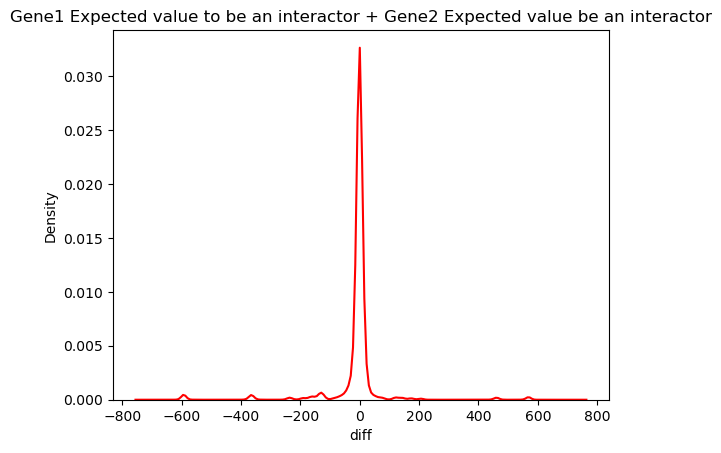

In [14]:
sns.kdeplot(df_meta['diff'], color = 'red')
plt.title(f'Gene1 Expected value to be an interactor + Gene2 Expected value be an interactor')
plt.show()

In [15]:
df_meta = subsetted.reset_index(drop = True).drop(['diff', 'diff1', 'diff2'], axis =1)

In [16]:
unbalanced_ratio = df_meta.interacting.value_counts()[True]/df_meta.interacting.value_counts()[False]
print(f'unbalanced_ratio:{unbalanced_ratio:.2f}')

gene_count = create_gene_count(df_meta, unbalanced_ratio)
weighted_average = np.round(gene_count['abs_diff_weighted'].sum()/gene_count['tot'].sum(),2)
print(f'{weighted_average=}')
df_meta = df_meta.merge(gene_count[['gene', 'diff']], left_on = 'gene1', right_on = 'gene').drop('gene', axis = 1).rename({'diff':'diff1'}, axis =1)
df_meta = df_meta.merge(gene_count[['gene', 'diff']], left_on = 'gene2', right_on = 'gene').drop('gene', axis = 1).rename({'diff':'diff2'}, axis =1)
df_meta['diff'] = df_meta['diff1'] + df_meta['diff2']

unbalanced_ratio:0.39
weighted_average=4.17


In [17]:
perc = np.round(100 - df_meta.shape[0]/original_shape*100, 2)
print(f'In total, I lost the:{perc}% of the pairs')

In total, I lost the:9.86% of the pairs


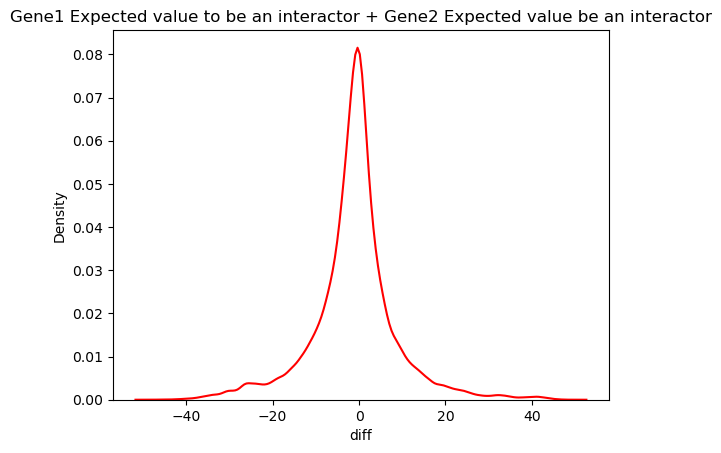

In [18]:
sns.kdeplot(df_meta['diff'], color = 'red')
plt.title(f'Gene1 Expected value to be an interactor + Gene2 Expected value be an interactor')
plt.show()

In [19]:
df_meta.to_csv(os.path.join(metadata_dir, f'{set_data}.csv'), index = False)

If you want to sample from problematics pair such that we have all the genes, comment this
```{python}
df_meta = subsetted.reset_index(drop = True).drop(['diff', 'diff1', 'diff2'], axis =1)
```
and uncomment this

```{python}
all_problematic_genes = set(problematics.gene2).union(set(problematics.gene1))
genes_to_sample = all_problematic_genes - set(subsetted.gene1).union(set(subsetted.gene2))

id_to_keep = []
for gene in genes_to_sample:
    subset = problematics[(problematics.gene1 == gene) | (problematics.gene2 == gene)]
    n_sample = min(3,subset.shape[0])
    #n_sample = 1
    id_to_keep = id_to_keep + list(subset.sample(n_sample)['id_sample'])
id_to_keep = set(id_to_keep)
problematics_to_sample = problematics[problematics.id_sample.isin(id_to_keep)]

df_meta = pd.concat([subsetted, problematics_to_sample], axis = 0).reset_index(drop = True).drop(['diff', 'diff1', 'diff2'], axis =1)
assert all_problematic_genes - set(df_meta.gene2).union(set(df_meta.gene1)) == set()
```

In [ ]:
#NEL COLLATE_FN METTI UNA AUGMENTATION CHE SWAPPO RANDOM I PRIMI E GLI UTLIMI 2560 VALORI DEL VETTORE DI INPUT

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler

class MeanEmbDataset(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.samples = []
        self.labels = []
        for class_label in ['class_0', 'class_1']:
            class_folder = os.path.join(folder_path, class_label)
            for sample_file in os.listdir(class_folder):
                sample = np.load(os.path.join(class_folder, sample_file))
                self.samples.append(sample)
                self.labels.append(int(class_label.split('_')[1]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        label = self.labels[idx]
        return torch.from_numpy(sample).float(), label

def create_data_loader(folder_path, batch_size, unbalanced_factor = 0.3):
    dataset = MeanEmbDataset(folder_path)

    # count the number of samples for each class
    class_sample_count = [0, 0]
    for label in dataset.labels:
        class_sample_count[label] += 1

    # calculate the weights for each sample
    weight_per_class = [0.0, 0.0]
    weight_per_class[0] = 1.0  # keep all samples from class 0
    weight_per_class[1] = 1.0 / class_sample_count[1] * unbalanced_factor  # undersample class 1
    weights = [weight_per_class[label] for label in dataset.labels]

    # create a weighted sampler to sample the data
    sampler = WeightedRandomSampler(weights, len(weights))

    # create a data loader with the weighted sampler
    data_loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)
    return data_loader